# Data analysis for HRV and MET received through device

Using MAXIM maxref103 to receive data through bluetooth. 

Data received come in the format of raw PPG with peak detection and accelerometer with sampling of around 25 samples a second. 

## First, HRV

In [ ]:
import pandas as pd
import pathlib

df = pd.read_csv("trial_HRM.csv")

### Get and plot data

In [43]:
import matplotlib.pyplot as plt
import numpy as np

#get magnitude of PPG measurement
amp = df['green']
amp_array = amp.to_numpy()

samples = df['sample_count']
rr = df['rr']
timestamp = df['sample_time']

#normalize
max = np.max(amp_array)
min = np.min(amp_array)

amp_array_norm = (amp_array - min) / (max - min)

In [44]:
#get synthetic acceleration 
acx = df['acceleration_x']
acy = df['acceleration_y']
acz = df['acceleration_z']

syn_ac = np.square(acx) + np.square(acy) + np.square(acz)
syn_ac = np.power(syn_ac, 1/2)

In [ ]:
#get rr and clean rr
rr_nz = rr[rr!=0]
rr_array = rr_nz.to_numpy()

#### Denoising by outlier detection and removal. Zero time data have already been removed from RR interval signal (since it is sampled at the same time as raw PPG)

Remains to be done: try denoising by acceleration. 

In [ ]:
#do IQR on RR signal to remove outliers and clean rr
import numpy as np

Q1 = np.percentile(rr_array, 25)
Q3 = np.percentile(rr_array, 75)

IQR = Q3 - Q1

print(IQR)

iqr_min = Q1 - 1.5*IQR
iqr_max = Q3 + 1.5*IQR

rr_array_clean = rr_array[(rr_array <iqr_max) & (rr_array>iqr_min)]


237.5
306.35 1256.35


#### Plotting PPG, RR interval and acceleration signals to notice noise trends.

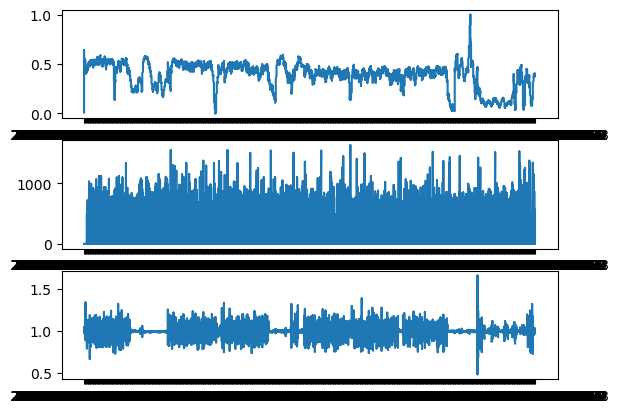

In [47]:
#get the PPG, RR, acc plot
figure, axis = plt.subplots(3)
axis[0].plot(timestamp, amp_array_norm)
axis[1].plot(timestamp, rr)
axis[2].plot(timestamp, syn_ac)

#rr plot seems to follow the direction of PPG measurement as opposed to acceleration which appears to be random here making everything a bit complicated 

### RMSSD 

In [48]:
import numpy as np

#RMSSD 
#removing all zero values to get only actual IBIs
rr_nz = rr[rr!=0]

#RMSSD: root mean square of successive differences
#turn this into a function at some point 
rr_nz_array = rr_nz.to_numpy() #float64 

itersize = rr_nz_array.size
squares = 0

for i in range(itersize-2) : 
    squares += np.square(rr_nz_array[i+1] - rr_nz_array[i])

average = squares / (itersize-1)

RMSSD = np.power(average, 1/2)

print(RMSSD)

#you get RMSSD here but you need to use that later to compare between different samples
#turn it into a function to use whenever 


331.0480047219925


### SPECTRAL ANALYSIS

#### FFT with interpolation and clean data

In [49]:
from scipy.fft import rfft, rfftfreq
from scipy.fft import fft, fftfreq

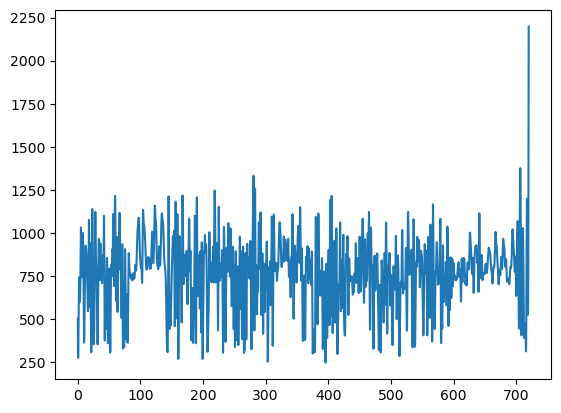

In [ ]:
#gets and plots interpolated time data of RR interval

time_size = rr_array_clean.size
times = np.empty(time_size, dtype = int)

#clean times 
for i in range(time_size): 
    times[i] = i

uniform_times = np.arange(0, time_size, 1/fs) #make a uniform time array so as to also uniform the signal and then do FFT
from scipy.interpolate import CubicSpline
import numpy as np

#do cubic spline interpolation which is better suited for HRV
cs = CubicSpline(times, rr_array_clean)
interpolated_rr = cs(uniform_times)

plt.plot(uniform_times, interpolated_rr) #interpolated has negative times which MAKES NO SENSE GENERALLY SPEAKING

(0.0, 1.0)

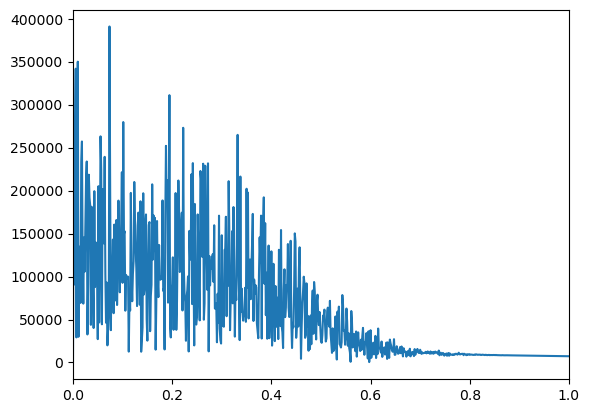

In [69]:
#gets and plots FFT of previous data after interpolation

from scipy.fft import rfft, rfftfreq
n = interpolated_rr.size
fs = 25

interpolated_rr = interpolated_rr - np.mean(interpolated_rr) #remove DC 

rfft = rfft(interpolated_rr)
rfftfreq = rfftfreq(n, 1/fs)

plt.plot(rfftfreq, np.abs(rfft)) #plots magnitude in frequency of data
plt.xlim(0, 1)

(0.0, 1.0)

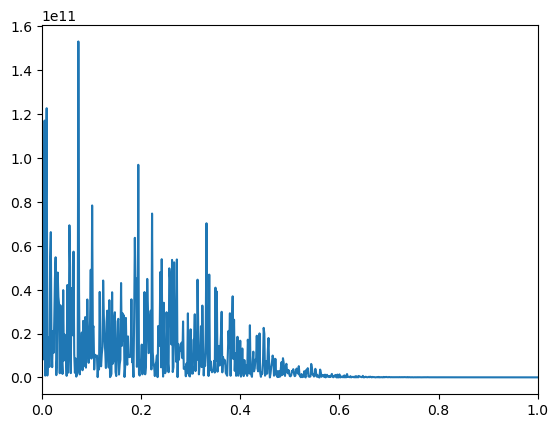

In [68]:
#gets and plots the power of previous spectrum

mag = np.abs(rfft)
power = mag**2

plt.plot(rfftfreq, power)
plt.xlim(0, 1)


In [65]:
#gets the HF, LF, HF/LF parameters to be used in the neural network 

lf_mask = (rfftfreq >= 0.04) & (rfftfreq <= 0.15)
lf_power = np.trapz(power[lf_mask], rfftfreq[lf_mask])

hf_mask = (rfftfreq >= 0.15) & (rfftfreq <= 0.4)
hf_power = np.trapz(power[hf_mask], rfftfreq[hf_mask])

total_power = lf_power + hf_power 
lf_nu = lf_power/total_power
hf_nu = hf_power/total_power

print(lf_nu, hf_nu)

0.3499042974501477 0.6500957025498523


### Left to be done: 

Maybe do autoregression for smoothing. 

Move into writing the network and Fanger's model for comparison. 

Do more time-domain methods to train the network. 

Gather data (5 min intervals) and get results. 

Combine everything into one file and write experiment down. 

Write results. 

## Then, MET

### First method is calculating MET through calories burnt while doing an activity. The files received from the device contain accumulative calories which means I will have to look into the equation a little bit. 

In [55]:
#MET = cal / (kg * hours)
import pandas as pd 

kg =  64

df = pd.read_csv('trial_HRM.csv')

cal = df['calorie']
timestamp = df['sample_time']
time_size = timestamp.size

#get calories
cal_size = cal.size 
calories = cal[cal_size-1]

#get duration of exercise in hours
t1 = pd.to_datetime(timestamp[0])
t2 = pd.to_datetime(timestamp[time_size-1])
duration = (t2-t1).seconds/(60*60)

#calculate MET
total_MET = calories / (64*duration)



## Now, neural network